# Agente detector de IA

In [23]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [24]:
from typing import Dict, List, Annotated, TypedDict, Literal

from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate, ChatPromptTemplate
from langchain.output_parsers.openai_tools import JsonOutputKeyToolsParser

from langgraph.graph import StateGraph, START, END

from pydantic import BaseModel, Field

#### Estado del agente

In [25]:
class AnalysisFeatures(TypedDict):
    repeticiones: float
    coherencia: float
    complejidad_sintactica: float
    diversidad_lexica: float

class OverallState(TypedDict):
    texto: str
    analisis_preliminar: str
    caracteristicas: AnalysisFeatures
    patrones_detectados: List[str]
    conclusion: str
    score_ia: int  # Score de 0 a 100

#### Nodos del agente

In [51]:
def analisis_preliminar_texto(state: OverallState) -> OverallState:
    """Realiza un análisis preliminar del texto a evaluar."""
    
    llm = ChatOpenAI(
        temperature=0, 
        model="gpt-4o-mini"
    )
    
    prompt_template = """
    Analiza el siguiente texto y describe tus impresiones iniciales sobre si podría haber sido generado por IA:
    
    TEXTO A ANALIZAR:
    "{texto}"
    
    Considera aspectos como:
    - Naturalidad del lenguaje
    - Estructura y ritmo
    - Presencia de patrones repetitivos
    - Uso de frases genéricas o plantillas comunes
    
    Proporciona solo un análisis breve y objetivo.
    """
    
    prompt = PromptTemplate.from_template(
        template=prompt_template,
        partial_variables={"texto": state['texto']}
    )
    
    chain = prompt | llm
    
    response = chain.invoke({})
        
    return {"analisis_preliminar": response.content}

In [52]:
def extraer_caracteristicas(state: OverallState) -> OverallState:
    """Extrae características lingüísticas cuantificables del texto."""
    
    class Carateristicas(BaseModel):
        repeticiones: float = Field(..., description="Frecuencia de patrones repetitivos")
        coherencia: float = Field(..., description="Nivel de coherencia temática y de flujo")
        complejidad_sintactica: float = Field(..., description="Variedad en estructura de oraciones")
        diversidad_lexica: float = Field(..., description="Variedad de vocabulario")
    
    llm = ChatOpenAI(
        temperature=0, 
        model="gpt-4o-mini"
    )
    
    llm = llm.bind_tools(tools=[Carateristicas], tool_choice="Carateristicas")
    parser = JsonOutputKeyToolsParser(key_name="Carateristicas", first_tool_only=True)
    
    prompt_template = """
    Analiza el siguiente texto y calcula los siguientes indicadores en una escala de 0.0 a 1.0:
    
    TEXTO A ANALIZAR:
    "{texto}"
    
    1. Repeticiones: Frecuencia de patrones repetitivos (0=sin repeticiones, 1=altamente repetitivo)
    2. Coherencia: Nivel de coherencia temática y de flujo (0=incoherente, 1=perfectamente coherente)
    3. Complejidad sintáctica: Variedad en estructura de oraciones (0=muy simple, 1=muy compleja)
    4. Diversidad léxica: Variedad de vocabulario (0=muy limitada, 1=muy diversa)
    """
    
    prompt = PromptTemplate.from_template(
        template=prompt_template,
        partial_variables={"texto": state['texto']}
    )
    
    chain = prompt | llm | parser
    
    response = chain.invoke({})
    
    caracteristicas_dict = {
        "repeticiones": response["repeticiones"],
        "coherencia": response["coherencia"],
        "complejidad_sintactica": response["complejidad_sintactica"],
        "diversidad_lexica": response["diversidad_lexica"]
    }
    
    return {"caracteristicas": caracteristicas_dict}

In [53]:
def detectar_patrones(state: OverallState) -> OverallState:
    """Detecta patrones específicos comunes en textos generados por IA."""
    
    class Patrones(BaseModel):
        patrones: List[str] = Field(..., description="Lista de patrones detectados")
    
    llm = ChatOpenAI(
        temperature=0, 
        model="gpt-4o-mini"
    )
    
    llm = llm.bind_tools(tools=[Patrones], tool_choice="Patrones")
    parser = JsonOutputKeyToolsParser(key_name="Patrones", first_tool_only=True)
    
    prompt_template = """
    Analiza el siguiente texto e identifica la presencia de patrones típicos de texto generado por IA.
    
    TEXTO A ANALIZAR: 
    "{texto}"
    
    Busca específicamente:
    1. Frases introductorias genéricas ("Es importante señalar que", "Cabe destacar que")
    2. Estructuras enumerativas excesivas o listas
    3. Neutralidad excesiva o falta de posicionamiento
    4. Uso de frases de transición predecibles
    5. Redundancias o repetición de ideas
    6. Exceso de calificativos o adverbios
    7. Conclusiones genéricas o vacías
    8. Explicaciones demasiado didácticas
    
    Devuelve SOLO una lista de los patrones detectados (sin explicaciones adicionales).
    """
    
    prompt = PromptTemplate.from_template(
        template=prompt_template,
        partial_variables={"texto": state['texto']}
    )
    
    chain = prompt | llm | parser
    
    response = chain.invoke({})["patrones"]
    
    return {"patrones_detectados": response}

In [57]:
def tomar_decision(state: OverallState) -> OverallState:
    """Integra todos los análisis y asigna un score de 0-100 (0=humano, 100=IA)."""
    
    class Score(BaseModel):
        score: int = Field(..., description="Score de 0 a 100 para determinar la probabilidad de IA (0=humano, 100=IA)")
        conclusion: str = Field(..., description="Conclusión detallada sobre el análisis")
    
    llm = ChatOpenAI(
        temperature=0, 
        model="gpt-4o-mini"
    )
    
    llm = llm.bind_tools(tools=[Score], tool_choice="Score")
    parser = JsonOutputKeyToolsParser(key_name="Score", first_tool_only=True)
    
    # Preparar el resumen de las características
    caracteristicas = state["caracteristicas"]
    patrones = "\n".join([f"- {p}" for p in state["patrones_detectados"]])
    
    system_prompt = """\
    Eres un experto en análisis de textos. Tu tarea es evaluar la probabilidad de que un texto haya sido generado por IA.
    Utiliza la información proporcionada para llegar a una conclusión fundamentada, toma el tiempo necesario para analizar\
    los resultados obtenidos previamente y llegar a una conclusion.
    
    Previamente has realizado un análisis preliminar del texto, has extraído características lingüísticas cuantificables\
    y has detectado patrones que son típicos de textos generados por IA.
    
    Tendras en cuenta los datos anteriores para llegar a:
    - Conclusiones y puntuación final
    
    ## Proporciona un score de 0 a 100, donde:
    - 0-20: Casi con certeza escrito por humano
    - 21-40: Probablemente escrito por humano
    - 41-60: Indeterminado
    - 61-80: Probablemente generado por IA
    - 81-100: Casi con certeza generado por IA
    
    El score debe ser un número entero exacto entre 0 y 100.
    
    ## Estructura tu respuesta claramente con estas dos secciones:
    No incluyas ninguna otra información o comentario adicional.
    - Conclusión: Explicación detallada de tu razonamiento
    - Score: Un número entero entre 0 y 100 que representa la probabilidad de que el texto haya sido generado por IA.
    """
    
    human_instructions = f"""\
    Según el análisis previo realizado a un texto, evalúa la probabilidad de que el texto haya sido generado por IA.
    
    Estas son las características del texto:
    
    ANÁLISIS PRELIMINAR:
    {state["analisis_preliminar"]}
    
    CARACTERÍSTICAS LINGÜÍSTICAS:
    - Repeticiones: {caracteristicas["repeticiones"]}
    - Coherencia: {caracteristicas["coherencia"]}
    - Complejidad sintáctica: {caracteristicas["complejidad_sintactica"]}
    - Diversidad léxica: {caracteristicas["diversidad_lexica"]}
    
    PATRONES DETECTADOS:
    {patrones}
    """
    
    texto = state["texto"]
    
    human_prompt = f"""\
    Este es el texto que se analizo y se obtuvieron las características anteriores:
    
    <texto>
    "{texto}"
    </texto>
    """
    
    messages = [
        SystemMessagePromptTemplate.from_template(system_prompt),
        HumanMessagePromptTemplate.from_template(human_instructions),
        HumanMessagePromptTemplate.from_template(human_prompt)
    ]
    
    prompt = ChatPromptTemplate.from_messages(messages=messages)
    
    chain = prompt | llm | parser
    
    response = chain.invoke({})
    
    state["conclusion"] = response["conclusion"]
    state["score_ia"] = response["score"]
    
    return state

#### Agente

In [58]:
graph = StateGraph(OverallState)

# Añadir nodos
graph.add_node("analisis_preliminar_texto", analisis_preliminar_texto)
graph.add_node("extraer_caracteristicas", extraer_caracteristicas)
graph.add_node("detectar_patrones", detectar_patrones)
graph.add_node("tomar_decision", tomar_decision)


graph.add_edge(START, "analisis_preliminar_texto")
graph.add_edge(START, "extraer_caracteristicas")
graph.add_edge(START, "detectar_patrones")

graph.add_edge("analisis_preliminar_texto", "tomar_decision")
graph.add_edge("extraer_caracteristicas", "tomar_decision") 
graph.add_edge("detectar_patrones", "tomar_decision")

graph.add_edge("tomar_decision", END)

app = graph.compile()

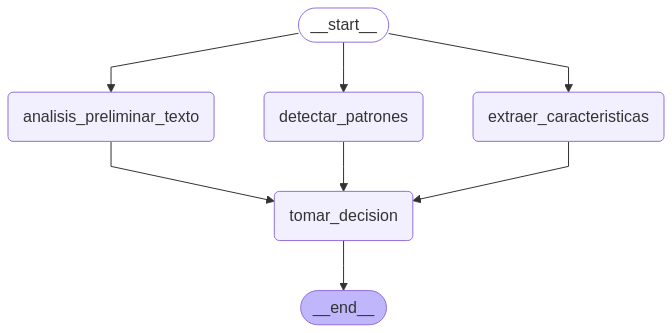

In [34]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

#### Pruebas:

In [59]:
solution = app.invoke({
    "texto": "El clima es un factor importante en la agricultura. Es esencial monitorear las condiciones climáticas para garantizar una cosecha exitosa. Las lluvias, la temperatura y la humedad son factores clave que afectan el crecimiento de los cultivos. Por lo tanto, es crucial prestar atención a estos aspectos para maximizar la producción agrícola."
})

In [60]:
print("SCORE IA:", solution["score_ia"])
print("-"*50)
print("conclusion:", solution["conclusion"])

SCORE IA: 75
--------------------------------------------------
conclusion: El análisis del texto revela características que son típicas de la escritura generada por IA. Aunque el lenguaje es claro y directo, lo que podría ser un indicativo de un autor humano, la falta de matices emocionales y la estructura lógica y uniforme sugieren un estilo más automatizado. Además, el uso de frases genéricas y la ausencia de profundidad en el contenido refuerzan la idea de que el texto podría haber sido generado por IA. Por lo tanto, se concluye que hay una alta probabilidad de que este texto haya sido creado por un sistema de inteligencia artificial.
